# Data Mining - Practical Session

In this hands-on session you will be taken through the process of creating movie recommendations based on the Movielens 1M dataset. 

To this end, we will undergo the following steps:
1. Load the data
2. Explore the data
3. Pre-process the data
4. Create a recommender model
5. Recommend movies

Let's get to it! 

### First we load the packages
Make sure that all the packages are installed correctly


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import model_selection
from sklearn.manifold import TSNE
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import PredictionImpossible
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import KNNWithMeans

### 1. Load the data 
We use the Movielens 100k observations dataset which is frequently used in the recommender field. In case your computer can handle this easily, you can also work with the 1M dataset which can be found in the bu folder.


In [2]:
# Load the data 
ratings = pd.read_csv("data/ratings.csv")
movies = pd.read_csv("data/movies.csv")

# add movie information to the ratings 
data = pd.merge(ratings, movies, how="left")

data.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


That is all the data we are going to use!
### 2. Explore the data 
Let's see how our data looks like


In [3]:
print("There are in total", len(data), "ratings from", data.movieId.nunique(), " movies and", data.userId.nunique(), "users.")

There are in total 100836 ratings from 9724  movies and 610 users.


In [4]:
# check if the formatting of the variables is ok
data.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object

In [5]:
# explore how many ratings we have per user 
user_freq = data[['userId', 'movieId']].groupby(['userId']).count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [6]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


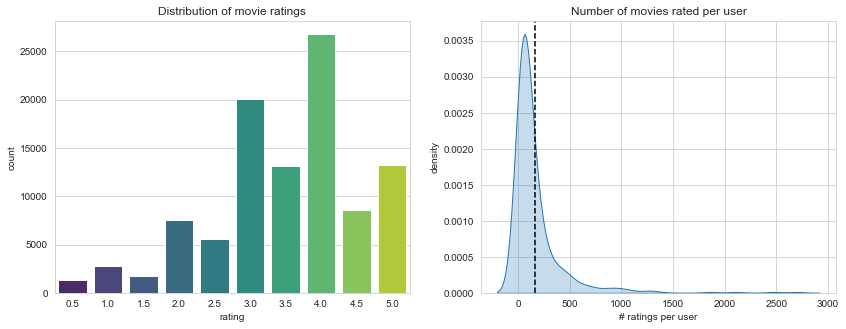

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=data, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

**Now, explore the different features of the dataset in isolation.** You can thing of the following questions:
1. How does the distribution look like of number of ratings per movie?
2. Which movies have been rated most often? 
3. Which movies have the highest and lowest rating?

In [8]:
# answer here

**Think about what this data exploration means for the model.** Some questions:
1. Most ratings are 4, what could then be a good random benchmark algorithm?
2. If people only rated 3 movies, should we include them?
3. Same for movies: when to include them?

# 3. Pre-process the data

1. Filter out the movies and users you want to include in the dataset
2. Calculate the sparsity of the data
3. Create a train and test set


In [9]:
min_number = 3

users_more_ratings = data.groupby("userId").count().reset_index().sort_values("movieId")
users_more_ratings = users_more_ratings[users_more_ratings["movieId"]>=min_number].userId.unique()

movies_more_ratings = data.groupby("movieId").count().reset_index().sort_values("userId")
movies_more_ratings = movies_more_ratings[movies_more_ratings["userId"]>=min_number].movieId.unique()

data = data[data["movieId"].isin(movies_more_ratings) & data["userId"].isin(users_more_ratings)]
print("There are in total", len(data), "ratings from", data.movieId.nunique(), " movies and", data.userId.nunique(), "users.")

There are in total 94794 ratings from 4980  movies and 610 users.


In [10]:
# Calculate Sparsity

### 4. Create a recommender model
**For this hands on we use the library "surprise" to create our recommender models** 
For more information check out this webste: https://surprise.readthedocs.io/en/stable/

We also restrict ourselves to collaborative filtering methods only. 
Remember, that means that we don't take user and movie features into account but only the matrix with ratings. 

In [11]:
# This is how we load the data. 

Matrix = data[["userId","movieId","rating"]]
reader = Reader(rating_scale=(1,5))
matrix = Dataset.load_from_df(Matrix, reader)

# Then we create a 80-20 split of train and test data
train_df, test_df = train_test_split(matrix, test_size=0.2, random_state=100)

### 4.1 Collaborative filtering: memory based - user
We use a K-NN method where we subtract the mean rating of every user. 

In [12]:
sim_options = {'name': 'cosine', 'min_support':1 ,'user_based': True }
recommender_KNN = KNNWithMeans(k=10, min_k=1, sim_options=sim_options, verbose=True)
recommender_KNN.fit(train_df)

original_train = train_df.build_testset()
predictions_train = recommender_KNN.test(original_train)
predictions = recommender_KNN.test(test_df)

print("RMSE on train data", accuracy.rmse(predictions_train, verbose=True))
print("RMSE on test data",accuracy.rmse(predictions, verbose=True))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7130
RMSE on train data 0.7129830710070995
RMSE: 0.8892
RMSE on test data 0.8891940172573102


**As you can see, there are a lot of parameters that can affect the algorithm performance and explain the overfitting on the test set. Try out some parameter values and see which one has a lot of effect**
If you change the min_k or the min_support, it might happen that some recommendations are not possible to give. The min_support for example tells how many items two users need to have in common before a similarity can be calculated. If you make recommendations with such a model, make sure to filter them out in the end (in the details column on the prediction) 

**Let's do a parameter sweep and investigate the best parameters**

In [13]:
param_grid = {'name': ['pearson', 'cosine'], 'min_support': [1], "user_based": ["True", "False"]
              , 'k':[10,40,60], 'min_k':[1]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(matrix)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [14]:
# Use these best parameters on the previous set up with a train and test split

### This is indeed a bit better! 
Let's investigate some more:
1. How does the confusion matrices look like of the test set(suppose that a rating of 3.5 or higher was indeed a good recommendation). 
2. How do we do compared to a benchmark that always predicts 3.5 (in terms of precision, recall and accuracy on test set)?
3. What are the best and worst predictions in the train and test set?

In [15]:
# First prep the data
predictions_train = pd.DataFrame(predictions_train, columns=['userId', 'movieId', 'rating', 'rating_p', 'details'])
predictions_test = pd.DataFrame(predictions, columns=['userId', 'movieId', 'rating', 'rating_p', 'details'])
train_matrix = pd.DataFrame(original_train, columns=['userId', 'movieId', 'rating'])
test_matrix = pd.DataFrame(test_df, columns=['userId', 'movieId', 'rating'])

train_matrix = pd.merge(train_matrix,predictions_train, on= ['userId', 'movieId', 'rating'], how="left")
test_matrix = pd.merge(test_matrix,predictions_test, on= ['userId', 'movieId', 'rating'], how="left")

In [16]:
# Create threshold values
train_matrix.loc[train_matrix["rating"] >=3.5,'rating_th'] = 1
train_matrix.loc[train_matrix["rating"] <3.5,'rating_th'] = 0
train_matrix.loc[train_matrix["rating_p"] >=3.5,'rating_p_th'] = 1
train_matrix.loc[train_matrix["rating_p"] <3.5,'rating_p_th'] = 0


confusion_matrix_train = pd.crosstab(train_matrix['rating_th'], train_matrix['rating_p_th'], rownames=['Actual'], colnames=['Predicted'])

print("train")
print(confusion_matrix_train)
print("Accuracy", np.round((confusion_matrix_train.loc[0,0] + confusion_matrix_train.loc[1,1])/ confusion_matrix_train.sum().sum(),2)  ) 
print("Recall", np.round( confusion_matrix_train.loc[1,1] /(confusion_matrix_train.loc[1,1]+confusion_matrix_train.loc[1,0]), 2))
print("Precision", np.round( confusion_matrix_train.loc[1,1] /(confusion_matrix_train.loc[1,1]+confusion_matrix_train.loc[0,1]), 2))

print("\n---Test")
# code here

train
Predicted    0.0    1.0
Actual                 
0.0        23752   5282
1.0        11409  35392
Accuracy 0.78
Recall 0.76
Precision 0.87

---Test


In [17]:
# confusion matrix of benchmark

### 4.2 Collaborative filtering: model based - MF

In [18]:
# We'll use the SVD algorithm that uses SGD to learn the weights
recommender_SVD = SVD(n_factors= 5, n_epochs = 10, reg_all = 0.1, lr_all = 0.1, verbose=False, biased=True)
recommender_SVD.fit(train_df)

original_train = train_df.build_testset()
predictions_train_SVD = recommender_SVD.test(original_train)
predictions_SVD = recommender_SVD.test(test_df)

print("RMSE on train data", accuracy.rmse(predictions_train_SVD, verbose=True))
print("RMSE on test data",accuracy.rmse(predictions_SVD, verbose=True))


RMSE: 0.7293
RMSE on train data 0.7293249868009529
RMSE: 0.8786
RMSE on test data 0.8785896580172473


**Repeat the exercise from above for this method**
Does this method give better results?

In [19]:
# answer here

### 5. Recommend movies

Let's take 1 user and use both algorithms to predict the recommended movies for these users

In [20]:
# Make prediction and are they different?
u = train_df.to_inner_uid(555)
i = train_df.to_inner_iid(7121)
print("user raw id:" , u, "item raw id: ",i)
user = train_df.to_raw_uid(u)
item = train_df.to_raw_iid(i)

# going to inner and back to raw id seems a bit redundant but using the raw id's immediately is not regocnised
print("KNN: ", recommender_KNN.predict(user, item))  
print("SVD: ", recommender_SVD.predict(user, item))  


user raw id: 41 item raw id:  3766
KNN:  user: 555        item: 7121       r_ui = None   est = 4.54   {'actual_k': 3, 'was_impossible': False}
SVD:  user: 555        item: 7121       r_ui = None   est = 4.33   {'was_impossible': False}


In [21]:
#Let's look at the top recommendations for user 555
make_recommendations = train_df.build_anti_testset()
recommendations = recommender_SVD.test(make_recommendations)

top_n = defaultdict(list)
for uid, iid, true_r, est, _ in recommendations:
    top_n[uid].append((iid, est))
    
# Then sort the predictions for each user and retrieve the k highest ones.
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:10]

In [22]:
top_n[555]

[(112421, 4.949493054697272),
 (26810, 4.916247148341365),
 (3089, 4.897555702560317),
 (89759, 4.8503413427479805),
 (1250, 4.841198673122085),
 (3266, 4.778080895423129),
 (4278, 4.777301758618248),
 (7842, 4.756876693788362),
 (1233, 4.742940719258279),
 (89904, 4.738294475607087)]

**We can also explore the model a bit and look at similar users**

In [23]:
inner_user_id = recommender_KNN.trainset.to_inner_uid(487)
print("user id: ", inner_user_id)
user_neigh = recommender_KNN.get_neighbors(inner_user_id, k=10)
user_neigh

user id:  439


[45, 81, 89, 93, 111, 124, 128, 138, 143, 159]

In [24]:
# Let's look at the movies of user 1
user_sim = train_df.to_raw_uid(1)
data[data["userId"]==user_sim].sort_values("rating", ascending=False).head(10)

,userId,movieId,rating,timestamp,title,genres
85983,558,5420,5.0,1035415871,Windtalkers (2002),Action|Drama|War
85966,558,5064,5.0,1035415811,The Count of Monte Cristo (2002),Action|Adventure|Drama|Thriller
85957,558,3831,5.0,1035415531,Saving Grace (2000),Comedy
85959,558,4159,5.0,1035416048,3000 Miles to Graceland (2001),Action|Thriller
85961,558,4306,5.0,1035416189,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
85950,558,3186,5.0,1035416294,"Girl, Interrupted (1999)",Drama
85962,558,4308,5.0,1035416273,Moulin Rouge (2001),Drama|Musical|Romance
85947,558,2568,5.0,1035416048,"Mod Squad, The (1999)",Action|Crime
85946,558,2297,5.0,1035416242,What Dreams May Come (1998),Adventure|Drama|Fantasy|Romance
85965,558,4993,5.0,1035415811,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy


In [25]:
# and user 439
sim_movie = train_df.to_raw_uid(439)
data[data["userId"]==sim_movie].sort_values("rating", ascending=False).head(10)

,userId,movieId,rating,timestamp,title,genres
78340,487,27611,5.0,1428574594,Battlestar Galactica (2003),Drama|Sci-Fi|War
78359,487,116797,4.5,1428650174,The Imitation Game (2014),Drama|Thriller|War
78321,487,4878,4.0,1428574246,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller
78357,487,109487,4.0,1428574546,Interstellar (2014),Sci-Fi|IMAX
78349,487,81845,4.0,1428574557,"King's Speech, The (2010)",Drama
78347,487,61240,4.0,1428574619,Let the Right One In (Låt den rätte komma in) ...,Drama|Fantasy|Horror|Romance
78345,487,56367,4.0,1428650046,Juno (2007),Comedy|Drama|Romance
78339,487,8961,4.0,1428574243,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
78338,487,8874,4.0,1428574269,Shaun of the Dead (2004),Comedy|Horror
78337,487,7438,4.0,1428574247,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller


**We can also check out which movies are similar looking at the latent vector spaces**

In [26]:
latent_movie = pd.DataFrame(recommender_SVD.qi, columns=['latent_1', 'latent_2', 'latent_3','latent_4','latent_5']) # for user latent factors use recommender_SVD.pu
latent_movie = latent_movie.reset_index()

In [27]:
# Add the latent factors to the movie information
inner_raw_item = pd.DataFrame.from_dict(train_df._raw2inner_id_items, orient='index')
inner_raw_item.column = inner_raw_item.rename(columns={0: "index"}, inplace=True)
inner_raw_item = inner_raw_item.reset_index()
inner_raw_item = pd.merge(latent_movie, inner_raw_item,how="left", on="index")
inner_raw_item = inner_raw_item.rename(columns={"level_0": "movieId"})
inner_raw_item = pd.merge(inner_raw_item,movies,how="left", on="movieId")
inner_raw_item.head(5)

,index,latent_1,latent_2,latent_3,latent_4,latent_5,movieId,title,genres
0,0,-0.167465,0.157536,0.028691,0.216822,0.082824,4010,Brewster's Millions (1985),Comedy
1,1,0.122751,0.261841,0.156831,0.425036,0.486494,3285,"Beach, The (2000)",Adventure|Drama
2,2,-0.154201,0.566327,0.588173,0.144102,0.575950,1272,Patton (1970),Drama|War
3,3,-0.151999,-0.469216,0.209874,0.113968,-0.272495,3253,Wayne's World (1992),Comedy
4,4,-0.355826,-0.039573,0.288253,0.473936,-0.011371,1084,Bonnie and Clyde (1967),Crime|Drama


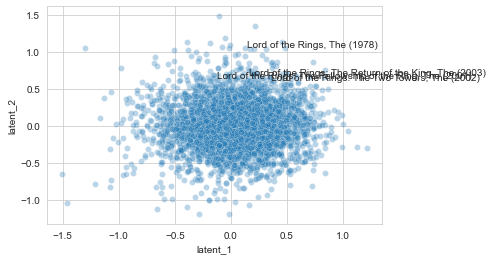

In [28]:
sns.scatterplot(
    x="latent_1", y="latent_2",
    #hue="label",
    #palette=sns.color_palette("hls", latent_movie["rating"].nunique()),
    data=inner_raw_item,
    legend="full",
    alpha=0.3,
)

# Test if the lord of the ring movies are close together
test_viz = inner_raw_item[inner_raw_item["title"].str.contains("Lord of the R")].reset_index()

for i, titl in enumerate (test_viz['title']):
    plt.text(test_viz['latent_1'][i]+0.2, test_viz['latent_2'][i]+0.2, titl)


** Optional: do the same for the users and check which users are close together **

#### That was the hands on, good job! Do you have time left? There is plenty to explore learn with this dataset on your own. Some ideas:

5.1 Optional: create an ensemble of the two different models (or any other) and see how that one performs on the test set. Does it improve performance (in RMSE or confusion matrix statistics)?

5.2 Optional: Try out the EASE model: https://github.com/Darel13712/ease_rec  

5.3 Optional: Add yourself as a user, add some ratings of movies that you have seen, and recommend movies for yourself